In [30]:
import pandas as pd
from IPython.display import SVG
import numpy as np

from sklearn import model_selection
from sklearn import metrics

from keras import layers
from keras import models
from keras.utils import plot_model
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import model_to_dot
from keras import backend as K

In [83]:
df = pd.read_csv('train.csv').sample(10000)


In [84]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
354784,354784,483945,129026,When you say I swear to god is it bad?,"Religion: If you could ask God one question, w...",0
95296,95296,56771,2475,What is the best gift you are ever received?,Which is the best gift that you have ever rece...,1
48899,48899,87094,87095,What is the perfect country for me?,What would the perfect country be like?,0
300915,300915,9821,423760,What is the difference between monarch and mon...,What is the difference between monarchy and ar...,0
257273,257273,372546,372547,How do I run WhatsApp on a proxy server?,How do I create proxy server?,0


In [85]:
df['question1'] = df['question1'].fillna('').str.lower().str.replace('[^A-Za-z0-9?!]+', ' ')
df['question2'] = df['question2'].fillna('').str.lower().str.replace('[^A-Za-z0-9?!]+', ' ')

In [86]:
df['question1_len'] = df['question1'].fillna('').apply(lambda r: len(r.split(' ')))
df['question2_len'] = df['question2'].fillna('').apply(lambda r: len(r.split(' ')))

In [87]:
df_train, df_val = model_selection.train_test_split(df)

In [94]:
x1_train = pad_sequences(df_train['question1'].apply(lambda r: one_hot(r, 500000)), 100)
x2_train = pad_sequences(df_train['question2'].apply(lambda r: one_hot(r, 500000)), 100)

x1_val = pad_sequences(df_val['question1'].apply(lambda r: one_hot(r, 500000)), 100)
x2_val = pad_sequences(df_val['question2'].apply(lambda r: one_hot(r, 500000)), 100)

## Siamese MaLSTM

Inspired from [How to predict Quora Question Pairs using Siamese Manhattan LSTM](https://medium.com/mlreview/implementing-malstm-on-kaggles-quora-question-pairs-competition-8b31b0b16a07)

/home/eric/code/venvs/data3/lib/python3.5/site-packages/ipykernel_launcher.py:18: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


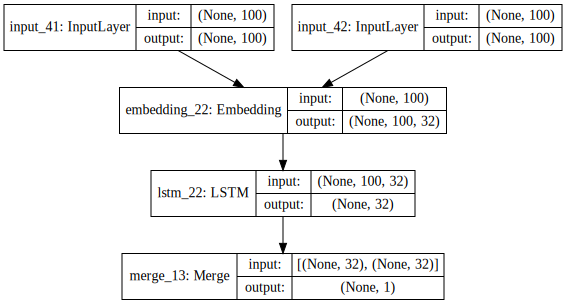

In [96]:
def exponent_neg_manhattan_distance(left, right):
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

shared_embedding = layers.Embedding(output_dim=32,
                                    input_dim=500000)

shared_lstm = layers.LSTM(32)

x1a = layers.Input(shape=(100,), dtype='int32')
h1a = shared_embedding(x1a)
h1a = shared_lstm(h1a)

x1b = layers.Input(shape=(100,), dtype='int32')
h1b = shared_embedding(x1b)
h1b = shared_lstm(h1b)

malstm_distance = layers.Merge(mode=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),
                               output_shape=lambda x: (x[0][0], 1))([h1a, h1b])

model = models.Model(inputs=[x1a, x1b],
                     outputs=[malstm_distance])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
model.fit(x=[x1_train, x2_train],
          y=df_train['is_duplicate'].values,
          validation_data=([x1_val, x2_val], df_val['is_duplicate'].values),
          epochs=3)

Train on 7500 samples, validate on 2500 samples
Epoch 1/3
7500/7500 [==============================] - 51s 7ms/step - loss: 0.2568 - acc: 0.5892 - val_loss: 0.2217 - val_acc: 0.6384
Epoch 2/3
7500/7500 [==============================] - 50s 7ms/step - loss: 0.1689 - acc: 0.7525 - val_loss: 0.2068 - val_acc: 0.6796
Epoch 3/3
1120/7500 [===>..........................] - ETA: 1:17 - loss: 0.1159 - acc: 0.8848